# eMERLIN Metadata in the CAOM Model 

This notebook will demonstrate the process for:
- Downloading e-MERLIN data
- Creating metadata from e-MERLIN measurement sets, images, plots, etc.
- Uploading aforementioned metadata to a relational database
- Querying the data via TAP
- Analysing the gaps in CAOM for e-MERLIN metadata

In [1]:
import wget

import pyvo as vo
from emerlin2caom2 import main_app
import plotting_sim_results as psr

data_update using version casarundata-2025.01.22-1.tar.gz, acquiring the lock ... 
'str' object has no attribute 'append'


2025-05-09 14:53:33	SEVERE	::casa	
2025-05-09 14:53:33	SEVERE	::casa	ERROR! Unexpected exception while doing auto updates or checking on the status of the data at measurespath
2025-05-09 14:53:33	SEVERE	::casa	visit https://casadocs.readthedocs.io/en/stable/notebooks/external-data.html for more information
2025-05-09 14:53:33	SEVERE	::casa	


## Setting up the Metadata Creation
The settings file for the metadata generation code houses all required user interaction including:
- The input data location
- The output metadata location
- The database url
- Required certificates
- Options for upload/replacement of metadata

In [25]:
# emerlin_data = wget.download("https://www.e-merlin.ac.uk/distribute/CY8/TS8004/TS8004_C_001_20190801.tar")
emerlin_data = 'TS8004_C_001_20190801'

In [26]:
settings_file = "/home/h14471mj/e-merlin/em_github/emerlin2caom/emerlin2caom2/settings_file.py"
xml_dir = "/home/h14471mj/e-merlin/metadata/{}".format(emerlin_data)
upload = 'True'
replace_old_data = 'True'
base_url = "http://localhost:8080/observations"
rootca = '/etc/ssl/certs/rootCA.pem'

In [27]:
settings_file_text = """
storage_name = '{0}'
xml_dir = '{1}'
upload = {2}
replace_old_data = {3}
base_url = {4}
rootca = {5}
""".format(emerlin_data, xml_dir, upload, replace_old_data, base_url, rootca)

In [8]:
print(settings_file_text)


storage_name = 'TS8004_C_001_20190801'
xml_dir = '/home/h14471mj/e-merlin/metadata/TS8004_C_001_20190801'
upload = True
replace_old_data = True
base_url = https://localhost:8080/observations
rootca = /etc/ssl/certs/rootCA.pem



In [ ]:
with open(settings_file, 'w') as f:
    f.write(settings_file_text)

## Metadata Creation and Upload

In [11]:
meta = main_app.EmerlinMetadata()
meta.build_metadata()

2025-05-09 13:55:50	INFO	msmetadata_cmpt.cc::open	Performing internal consistency checks on /home/h14471mj/e-merlin/data/TS8004_C_001_20190801/TS8004_C_001_20190801_avg.ms...
2025-05-09 13:55:50	INFO	MSMetaData::_computeScanAndSubScanProperties 	Computing scan and subscan properties...


No existing record found for TS8004_C_001_20190801_Mk2. Ok to ingest.
TS8004_C_001_20190801_Mk2 ingested.
No existing record found for TS8004_C_001_20190801_Kn. Ok to ingest.
TS8004_C_001_20190801_Kn ingested.
No existing record found for TS8004_C_001_20190801_De. Ok to ingest.
TS8004_C_001_20190801_De ingested.
No existing record found for TS8004_C_001_20190801_Pi. Ok to ingest.
TS8004_C_001_20190801_Pi ingested.
No existing record found for TS8004_C_001_20190801_Da. Ok to ingest.
TS8004_C_001_20190801_Da ingested.
No existing record found for TS8004_C_001_20190801_Cm. Ok to ingest.
TS8004_C_001_20190801_Cm ingested.
No existing record found for TS8004_C_001_20190801_1331+3030. Ok to ingest.
TS8004_C_001_20190801_1331+3030 ingested.
No existing record found for TS8004_C_001_20190801_1252+5634. Ok to ingest.
TS8004_C_001_20190801_1252+5634 ingested.
No existing record found for TS8004_C_001_20190801_1302+5748. Ok to ingest.
TS8004_C_001_20190801_1302+5748 ingested.
No existing record f

2025-05-09 13:55:51	INFO	msmetadata_cmpt.cc::open	Performing internal consistency checks on /home/h14471mj/e-merlin/data/TS8004_C_001_20190801/TS8004_C_001_20190801_avg.ms...
2025-05-09 13:55:51	INFO	MSMetaData::_computeScanAndSubScanProperties 	Computing scan and subscan properties...


-166.890475416667
-164.281394679167


2025-05-09 13:56:16	INFO	msmetadata_cmpt.cc::open	Performing internal consistency checks on /home/h14471mj/e-merlin/data/TS8004_C_001_20190801/splits/TS8004_C_001_20190801_1252+5634.ms/...
2025-05-09 13:56:16	INFO	MSMetaData::_computeScanAndSubScanProperties 	Computing scan and subscan properties...


No existing record found for TS8004_C_001_20190801. Ok to ingest.
TS8004_C_001_20190801 ingested.


## Querying the Metadata via TAP

In [19]:
query_url = base_url.replace('observations', 'tap')
service = vo.dal.TAPService(query_url)
resultset = service.search("SELECT * FROM derivedobservation")
derived_observation_id = resultset.to_table()['id'][0]

In [20]:
resultset = service.search("""
    SELECT t.name, p.* FROM Target t 
    JOIN Observation o ON o.target_id = t.id 
    JOIN point p ON t.id = p.id
    WHERE EXISTS (
        SELECT 1
        FROM Derivedobservation d 
        WHERE d.id = '{}' AND d.members LIKE '%' || o.uri || '%'
        )
;""".format(derived_observation_id))

In [23]:
resultset.to_table()

name,cval1,cval2,id,polygon_id
object,float64,float64,int64,int64
1331+3030,202.78453041666666,30.509155277777786,1,--
1252+5634,193.10952458333307,56.57208000000002,2,--
1302+5748,195.71860532083335,57.81044703333334,3,--
0319+4130,49.950667125,41.51169536111111,4,--
1407+2827,211.751643375,28.454080527777776,5,--


## Suitability of the CAOM for eMERLIN

In [8]:
list(psr.X)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [6]:
psr.create_uc_main(psr.requirements, psr.use_case_dict)

[1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


TypeError: unhashable type: 'numpy.ndarray'

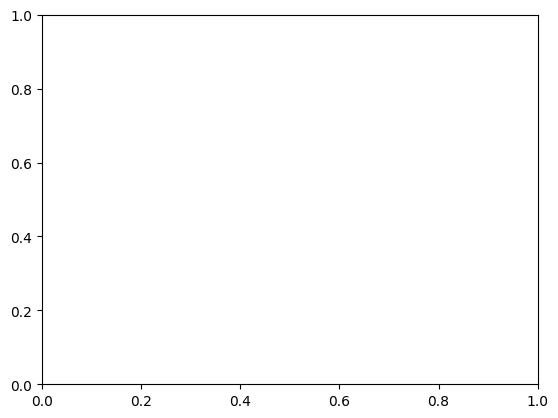

In [10]:
psr.create_graph(psr.X, psr.requirements, psr.create_uc_main(psr.requirements, psr.use_case_dict))

In [16]:
res_tab = ADQL_queries.use_case_queries(base_url.replace('observations', 'tap'), [1])

query number : 1


In [14]:
print()

https://localhost:8080/tap


In [17]:
res_tab

({'1': 0.07464313507080078}, {'1': 13})